# Analysis of HSC moderation of tied marks

## Summary
If school based assessment results in tied marks for first place, there is an overall benefit to the moderated HSC scores of the class if some means is used to separate the students. However, this process advantages highly ranked students at the expense of lower ranked students and has no educational jsutification.

## Rationale

Every year, around the end of term 3, there is a lot of discussion around the topic of what to do if two or more HSC students are tied for first place after school based assessment. This discussion arises from a perception that the [algorithm used by NESA to moderate school marks](https://educationstandards.nsw.edu.au/wps/portal/nesa/11-12/hsc/about-HSC/moderation), based on students' HSC examination performance, disadvantages students if tied results ae submitted. The dominant view dictates that students should be separated by some means, valid or otherwise. The alternative view is that separating students has no educational nor moral justification.

This analysis compares the effect of submitting tied top scores against the effect of separating them. Questions of whether such actions are justified are addressed at the end of the analysis.


## Method
The effect of NESA moderation on tied marks is explored using a Python simulation. A class of size `n` is assumed to have a normally distributed school based assessment with a specified `mean` and standard variation, `sd`. A set of school scores, `school_scores`, with at least 2 students on equal top mark is generated. This set of scores is then copied and the top places separated by adding 1 mark to the score of one of the top students, `school_scores_split`.

HSC examination scores are assumed to have a normally distributed variation from the school assessment scores with a standard deviation of `sd_delta`. The parameter `mean_delta` can be used to specify a mean change in examination scores relative to school assessment - this parameter can be positive, negative or 0.

This analysis is initially completed once and the moderated scores of the tied group is compared to that of the separated group to allow a visual appreciation of the effect of moderation. Because of the random generation, the results of this analysis change each time the analysis is run.

The analysis is then completed `runs` times, and the average effect of the moderation process on the scores of the tied and separated groups are compared by rank.

### Moderation algorithm

Moderation is achieved through a second order polynomial which maps the maximum, minimum and mean of the school scores to the maximum, minimum and mean of the exam scores. An overview of the moderation provess is given on the [NESA Moderation page](https://educationstandards.nsw.edu.au/wps/portal/nesa/11-12/hsc/about-HSC/moderation) and a more detailed description of the algorithms is given in [MacCann RG 1995 'The Moderation of Higher School Certificate Assessments using a Quadratic Polynomial Transformation: a Technical Paper', Board of Studies NSW.](../docs/MacCann_RG_1995_Moderation_Technical_Paper_BOS_NSW.pdf).

The process is summarised on the NESA website as follows:
> Moderation adjusts assessment marks using three anchor points:
> 
>> 1. The mean of the school group’s assessments is adjusted to equal the mean of the exam marks obtained by the students in that group.
>>
>> 2. The top assessment mark in a school group is adjusted to equal the highest exam mark obtained by any student in that group.
>>
>> 3. Where possible, the bottom moderated assessment is adjusted to equal the lowest exam mark obtained by any student in the group. This is not always possible when the distributions of the school assessment marks and the exam marks are very different. 
>
> If a school submits assessment marks with two (or more) students ranked first (tied on the top assessment mark), then the top moderated assessment mark will equal the average (mean) of the two (or more) highest exam marks for the school group. This also applies if students tie on the bottom assessment mark. The standard deviation is not used to moderate school assessment marks.


### Python Model
You can ignore this stuff if you like and skip to the next section. However if you are interested in the implementation code, or would like to help refine it or identify possible bugs, please read on. I have tried to make it as well commented as possible.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def test_min_max(in_array, min_limit, max_limit):
    '''Checks whether a numpy array is within defined limits.

    Returns:
        True if within the bounds, otherwise False
    '''
    return ((np.min(in_array) >= min_limit) and (np.max(in_array) <= max_limit))


def test_tied_condition(in_array, tied):
    ''' test whether the scores are tied as specified.

    Args:
        in_array (numpy array) - array to be checked
        tied (string) - a string describing the different tied states.
                valid values are:
                    'normal' no restriction on tied scores
                    'none' tied scores not allowed
                    'pair' exactly 2 tied scores required
                    'triple' exactly 3 tied scores required
                    'tie' if 2 or more tied scores required
    Returns:
        True if scores are tied as specified above, otherwise False
    '''
    
    if tied in ('tie', 'pair', 'triple'):
        if tied == 'pair':
            return ((in_array[0] == in_array[1]) and (in_array[1] != in_array[2]))
        elif tied == 'triple':
            return (in_array[0] == in_array[2])
        else:
            return (in_array[0] == in_array[1])
    elif tied == 'none':
        return (in_array[0] != in_array[1])
    else:
        return True


def generate_class_scores(n, mean, sd, min_score= 0, max_score= 100, tied='normal'):
    '''Generates randomly distributed class scores.

    Keeps generating random sets of scores until one is generated meeting the
    conditions specified by min, max and tied

    Args:.
        n (int > 3): number of students in the class
        mean (int): the arithmetic mean of the scores
        sd (float): the standard distribution of the scores
        min_score (int): the minimum allowable score
        max_score (int): the maximum allowable score
        tied (str): 'normal' no restriction on tied scores,
                    'none' tied scores not allowed
                    'pair' exactly 2 tied scores required
                    'triple' exactly 3 tied scores required
                    'tie' if 2 or more tied scores required

    Returns:
        class_scores (numpy array): the class scores.
    '''

    conditions_met = False

    while not conditions_met:

        class_scores = np.random.normal(mean, sd, n)
        class_scores = np.flip(np.sort(class_scores)) # order highest to lowest
        class_scores = np.rint(class_scores) 

        conditions_met = test_min_max(class_scores, min_score, max_score)

        if conditions_met:
            conditions_met = test_tied_condition(class_scores, tied)

    return class_scores


def generate_exam_scores(scores, mean_delta, sd_delta):
    '''Generates exam scores by adding a random number to school scores.

    Each score is varied independently by a random amount.
    Repeats if exam scores are not between 0 and 100.

    Args:
        scores (numpy array) - the school scores
        mean_delta (int) - the mean amount to add to the score. Scores will decrease
            on average if this is set to negative.
        sd_delta (float) - the standard deviation of the amount ot add to the scores

    Returns:
        exam (numpy array) - exam scores
    '''

    conditions_met = False

    while not conditions_met:
        exam = np.rint(scores + np.random.normal(mean_delta, sd_delta, n))
        conditions_met = test_min_max(exam, 0, 100)
        
    return exam

def check_ties(school, exam):
    '''Adjusts exam scores if top or bottom school marks are tied.

    If there are n tied school scores, the top exam score is set to the 
    mean of the top n exam scores. A similar adjustment is made for tied bottom scores. 

    Args:
        school (numpy array) - school assessment scores
        exam (numpy array) - exam scores

    Returns:
        exam_checked (numpy array) - sorted, and if required adjusted exam scores
    '''
    exam_checked = np.flip(np.sort(exam)) # sort into descending order
    n = np.size(school) 
    tied_firsts = 0
    tied_lasts = 0
    for i in range(1,n-1): # array indices start at 0
        if school[0] == school[i]:
            tied_firsts = i+1
        if school[n-1] == school[(n-1)-i]:
            tied_lasts = i+1
    
    if tied_firsts:
        high_score = np.sum(exam_checked[:tied_firsts])/(tied_firsts)
        exam_checked[:tied_firsts] = high_score
        
    if tied_lasts:
        low_score = np.sum(exam_checked[n-tied_lasts:])/(tied_lasts)
        exam_checked[n-tied_lasts:] = low_score
        
    return exam_checked
 
def get_stats(in_array):
    ''' Calculate the descriptive stats of a numpy array

    Args:
        in_array (numpy array) - data to be described

    Returns:
        stats_array (numpy array) - an array containing the max, min, mean
            standard deviation and sum of the input array
    '''
    stats_array = np.array([np.amax(in_array),
                    np.amin(in_array), 
                    np.mean(in_array), 
                    np.std(in_array), 
                    np.sum(in_array)])

    return stats_array

def moderate(school, exam):
    ''' moderate school scores as described by MacCann 1995.

    MacCann RG 1995 'The Moderation of Higher School Certificate Assessments using a 
        Quadratic Polynomial Transformation: a Technical Paper', Board of Studies NSW.

    Args:
        school (numpy array) - school assessment scores
        exam (numpy array) - exam scores

    Returns:
        moderated (numpy array) - moderated school scores    
    '''

    school_stats = get_stats(school)
    school_max = school_stats[0]
    school_min = school_stats[1]
    school_mean = school_stats[2]
    school_sd = school_stats[3]
    exam_stats = get_stats(exam)
    exam_max = exam_stats[0]
    exam_min = exam_stats[1]
    exam_mean = exam_stats[2]
    n = np.size(school)

    # start with special cases
    # n = 1
    if n == 1:
        moderated = exam

    # n = 2
    elif n == 2:
        mod_min = max(exam_min, (school_min/school_max)*exam_max)
        moderated = np.array([exam_max, mod_min])
    
    # all school ranks tied
    elif school_max == school_min:
        moderated = np.mean(exam)

    else:
        # n > 2 but only 2 distinct values
        if np.size(np.unique(school)) == 2:
            a = 0
            b = (exam_max - exam_min) / (school_max - school_min)
            c = exam_min - b * school_min

        # finally ya normal boi!
        else:
            # TODO make this more elegant
            exam = check_ties(school, exam)
            exam_stats = get_stats(exam)
            exam_max = exam_stats[0]
            exam_min = exam_stats[1]
            exam_mean = exam_stats[2]
    
            a_num = exam_max*(school_min-school_mean) - exam_min*(school_max-school_mean) + exam_mean*(school_max-school_min)
            a_denom = (school_max-school_min)*(school_sd**2 + (school_max-school_mean)*(school_min-school_mean))
            a = a_num/a_denom

            b = (exam_min - exam_mean - a*(school_min**2-school_mean**2-school_sd**2))/(school_min-school_mean)

            c = exam_min - school_min*(a*school_min + b)
        
        moderated = np.rint(np.polyval([a,b,c],school))

    return moderated
  

### Assumptions

The following inputs can be adjusted in the code box below to explore the effects of different assumptions on the modelled outcomes:

- n = 15; the number of students in the class
- mean = 65; the mean school assessment score
- sd = 15; the standard deviation of the school assessment scores
- school_max = 95; the maximum value for the school based asessment. Keep less than 100
- mean_imp = 5; the mean of the improvement in HSC examination scores compared to school based assessment. This can be set to a positive or negative value.
- sd_imp = 7; the standard deviastion of the improvement in HSC examination scores compared to school based assessment. 


In [3]:
n = 15
mean = 65
sd = 15
mean_delta = 4
sd_delta = 5
school_max = 95


Create n school assessment scores with tied top scores, then create a copy with the top scores separated.

In [5]:
school_scores = generate_class_scores(n, mean, sd, max_score=school_max, tied='tie')
school_scores_split = copy.deepcopy(school_scores)
school_scores_split[0] += 1

print(f'school scores:           {school_scores}')
print(f'separated school scores: {school_scores_split}')


school scores:           [82. 82. 82. 81. 78. 67. 55. 55. 51. 51. 50. 48. 44. 43. 35.]
separated school scores: [83. 82. 82. 81. 78. 67. 55. 55. 51. 51. 50. 48. 44. 43. 35.]


Create an array of HSC exam scores by randomly varying the the school scores.

In [6]:
exam_scores = generate_exam_scores(school_scores, mean_delta, sd_delta)
print(f'exam scores:             {exam_scores}')

exam scores:             [92. 80. 82. 87. 83. 76. 57. 50. 60. 64. 52. 52. 41. 48. 40.]


Moderate both sets of school scores.

In [7]:
moderated_scores = moderate(school_scores, exam_scores)
moderated_scores_split = moderate(school_scores_split, exam_scores)

print(f'moderated tied school scores:      {moderated_scores}')
print(f'moderated separated school scores: {moderated_scores_split}')

moderated tied school scores:      [87. 87. 87. 86. 83. 70. 58. 58. 54. 54. 53. 51. 48. 47. 40.]
moderated separated school scores: [92. 90. 90. 89. 84. 69. 56. 56. 52. 52. 51. 49. 46. 45. 40.]


Check that the moderated scores meet the condition of matching the top exam score, bottom exam score, exam mean and totl exam marks. If they dont meet these conditions (within a rounding error of 1) swear at me then let me know.

In [8]:
print(f'exam scores stats (max, min, mean, sd, sum):            {np.rint(get_stats(exam_scores))}')
print(f'moderated scores stats (max, min, mean, sd, sum):       {np.rint(get_stats(moderated_scores))}')
print(f'moderated scores split stats (max, min, mean, sd, sum): {np.rint(get_stats(moderated_scores_split))}')

exam scores stats (max, min, mean, sd, sum):            [ 92.  40.  64.  17. 964.]
moderated scores stats (max, min, mean, sd, sum):       [ 87.  40.  64.  17. 963.]
moderated scores split stats (max, min, mean, sd, sum): [ 92.  40.  64.  19. 961.]


Compare the resultant moderated and school scores for the tied group (blue) and the separated group (red). Because the results are randomly generated the shape of this graph will vary each time the analysis above is run. However, in most cases ti shows a clear bias in favour of the top students at the expense of the middle lower students.

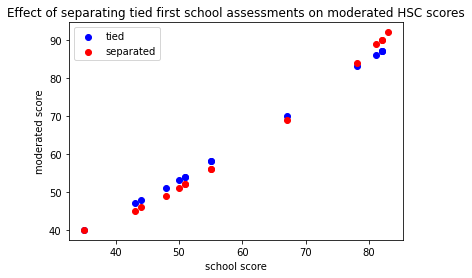

In [9]:
plt.scatter(school_scores, moderated_scores, c='blue', label='tied')
plt.scatter(school_scores_split, moderated_scores_split, c='red', label='separated')
plt.xlabel('school score')
plt.ylabel('moderated score')
plt.title('Effect of separating tied first school assessments on moderated HSC scores')
plt.legend()


Now lets do this `runs` times and see who the winners and losers are.

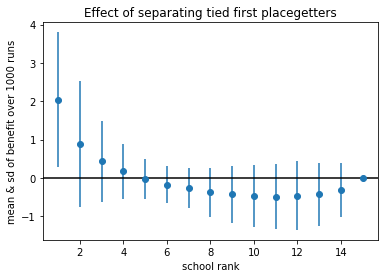

In [13]:
runs = 1000
winners_losers = np.empty(n)

#run runs times
for ctr in range(runs):
    school_scores = generate_class_scores(n, mean, sd, max_score=school_max, tied='tie')
    school_scores_split = copy.deepcopy(school_scores)
    school_scores_split[0] += 1

    exam_scores = generate_exam_scores(school_scores, mean_delta, sd_delta)
    
    moderated_scores = moderate(school_scores, exam_scores)
    moderated_scores_split = moderate(school_scores_split, exam_scores)

    # this is painful but numpy need to append like to like so...
    # see if you can spot the difference
    if ctr: # not the first run
        winners_losers = np.append(winners_losers, [(moderated_scores_split - moderated_scores)], axis = 0)
    else: #ctr == 0 so first run
        winners_losers = np.append([winners_losers], [(moderated_scores_split - moderated_scores)], axis = 0)
    

#plt.bar(np.arange(n) + 1, winners_losers / runs)
ranks = np.arange(1,n+1)
plt.figure()
plt.errorbar(ranks, np.mean(winners_losers, axis=0), yerr=np.std(winners_losers, axis=0), fmt='o')
plt.axhline(0, color='black')
plt.xlabel('school rank')
plt.ylabel(f'mean & sd of benefit over {runs} runs')
plt.title('Effect of separating tied first placegetters')
plt.show()

## Interpretation of results

The plot above shows the mean benefit by rank for the multiple runs. Each time this analysis hase been run, it is clear that separating tied students benefits the group overall, but the benefit is significantly skewed towards the better ranked students at the expense of those with lower ranks. Splitting top students who would otherwise be tied has no educational justification, but teachers may be able to justify it on the basis of an overall benefit to the class. However they need to acknowledge that by doing so they are in all likelyhood disadvantaging the lower ranked students.

 If you intend to play God remember..."to the one who has, more will be given, and from the one who has not, even what he thinks that he has will be taken away."